In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.slim.nets import vgg 
from sklearn.model_selection import train_test_split
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

/data/ducnt4/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cell_size = 7
box_per_cell = 2
img_size = 224
classes = {'circle':0, 'triangle':1,  'rectangle':2}
nclass = len(classes)

box_scale = 5.0
noobject_scale = 0.5
batch_size = 128
epochs = 100
lr = 1e-3

In [3]:
def load():
    labels = json.load(open('../data/yolo/train/labels.json'))
    N = len(labels)
    X = np.zeros((N, img_size, img_size, 3), dtype='uint8')
    y = np.zeros((N,cell_size, cell_size, 5+nclass))
    for idx, label in enumerate(labels):
        img = cv2.imread("../data/yolo/train/{}.png".format(idx))
        X[idx] = img/255.0
        for box in label['boxes']:
            x1, y1 = box['x1'], box['y1']
            x2, y2 = box['x2'], box['y2']
            cl = [0]*len(classes)
            cl[classes[box['class']]] = 1
            
            x_center, y_center, w, h = (x1+x2)/2.0, (y1+y2)/2.0, x2-x1, y2-y1
            x_idx, y_idx = int(x_center/img_size*cell_size), int(y_center/img_size*cell_size)
            y[idx, y_idx, x_idx] = 1, x_center, y_center, w, h, *cl
    
    return X, y

In [4]:
X, y = load()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

In [5]:
def compute_iou(boxes1, boxes2, scope='iou'):
    """calculate ious
    Args:
      boxes1: 5-D tensor [BATCH_SIZE, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 5-D tensor [BATCH_SIZE, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4] ===> (x_center, y_center, w, h)
    Return:
      iou: 4-D tensor [BATCH_SIZE, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    """
    with tf.variable_scope(scope):
        # transform (x_center, y_center, w, h) to (x1, y1, x2, y2)
        boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                             boxes1[..., 1] - boxes1[..., 3] / 2.0,
                             boxes1[..., 0] + boxes1[..., 2] / 2.0,
                             boxes1[..., 1] + boxes1[..., 3] / 2.0],
                            axis=-1)

        boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                             boxes2[..., 1] - boxes2[..., 3] / 2.0,
                             boxes2[..., 0] + boxes2[..., 2] / 2.0,
                             boxes2[..., 1] + boxes2[..., 3] / 2.0],
                            axis=-1)

        # calculate the left up point & right down point
        lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
        rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

        # intersection
        intersection = tf.maximum(0.0, rd - lu)
        inter_square = intersection[..., 0] * intersection[..., 1]

        # calculate the boxs1 square and boxs2 square
        square1 = boxes1[..., 2] * boxes1[..., 3]
        square2 = boxes2[..., 2] * boxes2[..., 3]

        union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)

    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)    

In [6]:
def vgg16(inputs, is_training):
    with tf.variable_scope("vgg_16"):
        with slim.arg_scope(vgg.vgg_arg_scope()):
            net = slim.repeat(inputs, 2, slim.conv2d, 16, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 32, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 2, slim.conv2d, 256, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')

            net = slim.conv2d(net, 512, [1, 1], scope='fc6')   

            net = slim.conv2d(net, 13, [1, 1], activation_fn=None, scope='fc7')
    return net

In [7]:
def loss_layer(predicts, labels, scope='loss_layer'):
    with tf.variable_scope(scope):
        offset = np.transpose(np.reshape(np.array(
            [np.arange(cell_size)] * cell_size * box_per_cell),
            (box_per_cell, cell_size, cell_size)), (1, 2, 0))
        offset = offset[None, :]
        offset = tf.constant(offset, dtype=tf.float32)
        offset_tran = tf.transpose(offset, (0, 2, 1, 3))
        predict_object = predicts[..., :box_per_cell]
        predict_box_offset = tf.reshape(predicts[...,box_per_cell:5*box_per_cell], (-1, cell_size, cell_size, box_per_cell, 4))
        predict_class = predicts[...,5*box_per_cell:]
        predict_normalized_box = tf.stack(
                                    [(predict_box_offset[..., 0] + offset) / cell_size,
                                     (predict_box_offset[..., 1] + offset_tran) / cell_size,
                                     tf.square(predict_box_offset[..., 2]),
                                    tf.square(predict_box_offset[..., 3])], axis=-1)
        
        true_object = labels[..., :1]
        true_box = tf.reshape(labels[..., 1:5], (-1, cell_size, cell_size, 1, 4))
        true_normalized_box = tf.tile(true_box, (1, 1, 1, box_per_cell, 1))/img_size
        true_class = labels[..., 5:]
        true_box_offset =  tf.stack(
                                    [true_normalized_box[..., 0] * cell_size - offset,
                                     true_normalized_box[..., 1] * cell_size - offset_tran,
                                     tf.sqrt(true_normalized_box[..., 2]),
                                     tf.sqrt(true_normalized_box[..., 3])], axis=-1)
        
        predict_iou = compute_iou(true_normalized_box, predict_normalized_box)
        
        object_mask = tf.reduce_max(predict_iou, 3, keepdims=True)  
        
        iou_metric = tf.reduce_mean(tf.reduce_sum(object_mask, axis=[1,2,3])/tf.reduce_sum(true_object, axis=[1,2,3]))
        
        object_mask = tf.cast((predict_iou>=object_mask), tf.float32)*true_object

        noobject_mask = tf.ones_like(object_mask) - object_mask
        
        ## class loss
        class_delta = true_object*(predict_class - true_class)
        class_loss = tf.reduce_mean(tf.reduce_sum(tf.square(class_delta), axis=[1,2,3]), name='class_loss')
        ## object loss
        object_delta = object_mask*(predict_object - predict_iou)
        object_loss = tf.reduce_mean(tf.reduce_sum(tf.square(object_delta), axis=[1,2,3]), name='object_loss')
        ## noobject loss
        noobject_delta = noobject_mask*predict_object
        noobject_loss = tf.reduce_mean(tf.reduce_sum(tf.square(noobject_delta), axis=[1,2,3]), name='noobject_loss')
        ## coord loss
        box_mask = tf.expand_dims(object_mask, 4)
        box_delta = box_mask*(predict_box_offset - true_box_offset)
        box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(box_delta), axis=[1,2,3]), name='box_loss')
        
        loss = 0.5*class_loss + object_loss + 0.1*noobject_loss + 10*box_loss
        
        return loss, iou_metric, predict_object, predict_class, predict_normalized_box

In [8]:
graph = tf.Graph()
with graph.as_default():    
    images = tf.placeholder("float", [None, img_size, img_size, 3], name="input")
    labels = tf.placeholder('float', [None, cell_size, cell_size, 8], name='label')
    is_training = tf.placeholder(tf.bool)

    logits = vgg16(images, is_training)
    loss, iou_metric, predict_object, predict_class, predict_normalized_box = loss_layer(logits, labels)
            
    optimizer = tf.train.AdamOptimizer(lr)
    train_op = optimizer.minimize(loss)

In [9]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=1)

    for epoch in range(epochs):
        start_time = time.time()
        for batch in range(len(X_train)//batch_size):
            X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
            y_batch = y_train[batch*batch_size:(batch+1)*batch_size]
            train_total_loss, train_iou_m,_ = sess.run([loss, iou_metric, train_op], {images:X_batch, labels:y_batch, is_training:True})            
        end_time = time.time()
        
        val_loss = []
        val_iou_ms = []
        for batch in range(len(X_test)//batch_size):
            val_X_batch = X_test[batch*batch_size:(batch+1)*batch_size]
            val_y_batch = y_test[batch*batch_size:(batch+1)*batch_size]
            total_val_loss, val_iou_m, val_predict_object, val_predict_class, val_predict_normalized_box = sess.run([loss, iou_metric, predict_object, predict_class, predict_normalized_box], 
                                                 {images:val_X_batch, labels:val_y_batch, is_training:False})
            val_loss.append(total_val_loss)
            val_iou_ms.append(val_iou_m)
            
        saver.save(sess, './model/yolo', global_step=epoch)
        print('epoch: {} - running_time: {:.0f}s - train_loss: {:.3f} - train_iou: {:.3f} - val_loss: {:.3f} - val_iou: {:.3f}'.format(epoch, end_time - start_time, train_total_loss, train_iou_m, np.mean(val_loss), np.mean(val_iou_ms)))

epoch: 0 - running_time: 94s - train_loss: 1.347 - train_iou: 0.392 - val_loss: 1.289 - val_iou: 0.509
epoch: 1 - running_time: 88s - train_loss: 0.323 - train_iou: 0.610 - val_loss: 0.319 - val_iou: 0.595
epoch: 2 - running_time: 87s - train_loss: 0.188 - train_iou: 0.653 - val_loss: 0.210 - val_iou: 0.669
epoch: 3 - running_time: 89s - train_loss: 0.160 - train_iou: 0.653 - val_loss: 0.186 - val_iou: 0.642
epoch: 4 - running_time: 89s - train_loss: 0.130 - train_iou: 0.723 - val_loss: 0.164 - val_iou: 0.663
epoch: 5 - running_time: 89s - train_loss: 0.127 - train_iou: 0.796 - val_loss: 0.143 - val_iou: 0.701
epoch: 6 - running_time: 89s - train_loss: 0.124 - train_iou: 0.785 - val_loss: 0.128 - val_iou: 0.754
epoch: 7 - running_time: 89s - train_loss: 0.084 - train_iou: 0.804 - val_loss: 0.107 - val_iou: 0.790
epoch: 8 - running_time: 89s - train_loss: 0.110 - train_iou: 0.773 - val_loss: 0.127 - val_iou: 0.769
epoch: 9 - running_time: 89s - train_loss: 0.076 - train_iou: 0.825 - val

epoch: 79 - running_time: 87s - train_loss: 0.018 - train_iou: 0.916 - val_loss: 0.074 - val_iou: 0.893
epoch: 80 - running_time: 87s - train_loss: 0.017 - train_iou: 0.911 - val_loss: 0.077 - val_iou: 0.888
epoch: 81 - running_time: 87s - train_loss: 0.019 - train_iou: 0.912 - val_loss: 0.075 - val_iou: 0.889
epoch: 82 - running_time: 87s - train_loss: 0.045 - train_iou: 0.814 - val_loss: 0.097 - val_iou: 0.810
epoch: 83 - running_time: 88s - train_loss: 0.019 - train_iou: 0.903 - val_loss: 0.075 - val_iou: 0.878
epoch: 84 - running_time: 87s - train_loss: 0.017 - train_iou: 0.914 - val_loss: 0.078 - val_iou: 0.886
epoch: 85 - running_time: 87s - train_loss: 0.034 - train_iou: 0.867 - val_loss: 0.079 - val_iou: 0.854
epoch: 86 - running_time: 87s - train_loss: 0.021 - train_iou: 0.899 - val_loss: 0.081 - val_iou: 0.875
epoch: 87 - running_time: 87s - train_loss: 0.018 - train_iou: 0.907 - val_loss: 0.073 - val_iou: 0.879
epoch: 88 - running_time: 87s - train_loss: 0.015 - train_iou: 0

In [10]:
def iou(box1, box2):
        tb = min(box1[0] + 0.5 * box1[2], box2[0] + 0.5 * box2[2]) - \
            max(box1[0] - 0.5 * box1[2], box2[0] - 0.5 * box2[2])
        lr = min(box1[1] + 0.5 * box1[3], box2[1] + 0.5 * box2[3]) - \
            max(box1[1] - 0.5 * box1[3], box2[1] - 0.5 * box2[3])
        inter = 0 if tb < 0 or lr < 0 else tb * lr
        return inter / (box1[2] * box1[3] + box2[2] * box2[3] - inter)
    
def interpret_output(predict_object, predict_class, predict_normalized_box):
    predict_box= predict_normalized_box*img_size
    predict_object = np.expand_dims(predict_object, axis=-1)
    predict_class = np.expand_dims(predict_class, axis=-2)
    class_probs = predict_object*predict_class
    
    filter_mat_probs = np.array(class_probs >= 0.2, dtype='bool')
    filter_mat_boxes = np.nonzero(filter_mat_probs)
    boxes_filtered = predict_box[filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]
    class_probs_filtered = class_probs[filter_mat_probs]
       
    classes_num_filtered = np.argmax(
        filter_mat_probs, axis=3)[
        filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]

    argsort = np.array(np.argsort(class_probs_filtered))[::-1]
    boxes_filtered = boxes_filtered[argsort]
    class_probs_filtered = class_probs_filtered[argsort]
    classes_num_filtered = classes_num_filtered[argsort]

    for i in range(len(boxes_filtered)):
        if class_probs_filtered[i] == 0:
            continue
        for j in range(i + 1, len(boxes_filtered)):
            if iou(boxes_filtered[i], boxes_filtered[j]) > 0.5:
                class_probs_filtered[j] = 0.0

    filter_iou = np.array(class_probs_filtered > 0.0, dtype='bool')
    boxes_filtered = boxes_filtered[filter_iou]
    class_probs_filtered = class_probs_filtered[filter_iou]
    classes_num_filtered = classes_num_filtered[filter_iou]

    result = []
    for i in range(len(boxes_filtered)):
        result.append(
            [classes_num_filtered[i],
             boxes_filtered[i][0],
             boxes_filtered[i][1],
             boxes_filtered[i][2],
             boxes_filtered[i][3],
             class_probs_filtered[i]])

    return result


In [32]:
img_idx = 8
result = interpret_output(val_predict_object[img_idx], val_predict_class[img_idx], val_predict_normalized_box[img_idx])

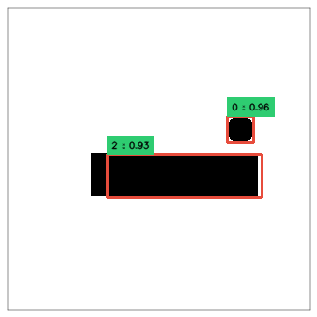

In [33]:
def draw_result(img, result):
    plt.figure(figsize=(10,10), dpi=40)
    img = np.pad(img, [(50,50), (50,50), (0,0)], mode='constant', constant_values=255)
    for i in range(len(result)):
        x = int(result[i][1])+50
        y = int(result[i][2])+50
        w = int(result[i][3] / 2)
        h = int(result[i][4] / 2)
        cv2.rectangle(img, (x - w, y - h), (x + w, y + h), (231, 76, 60), 2)
        cv2.rectangle(img, (x - w, y - h - 20),
                      (x -w + 50, y - h), (46, 204, 113), -1)
        cv2.putText(
            img, '{} : {:.2f}'.format(result[i][0] ,result[i][5]),
            (x - w + 5, y - h - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.3,
            (0, 0, 0), 1, cv2.LINE_AA)

    #
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
            
draw_result(val_X_batch[img_idx]*255, result)            

In [13]:
# x = np.nonzero(val_y_batch[img_idx][:,:,0])
# x_label =  np.concatenate([val_y_batch[img_idx][x[0], x[1]][:,:5],
#         np.argmax(val_y_batch[img_idx][x[0], x[1]][:,5:], axis=1).reshape((5,1))],
#                   axis=-1)
# draw_result(val_X_batch[img_idx]*255, x_label)            